# Test classification of underwater vegetation based on hyperspectral images

This notebook demonstrates how a hyperspectral image with corresponding "ground truth" annotation of vegetation can be used for classifying the image - bascally making a map of vegetation types. It is not meant to be "strict" in following recommended guidelines on training and validation data set design, but rather a simple proof of concept.

In [1]:
#%% Imports
import os
import numpy as np
import spectral
import matplotlib.pyplot as plt
from skimage import exposure, io
import json

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


In [2]:
#%% Paths
# If the dataset has the same structure as on Box, only base_data_dir needs to be changed
base_data_dir = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Hyperspectral'
transect_dir = os.path.join(base_data_dir,'Transects/Transect1-15m-AGL')

# Hyperspectral
trans1_hyperspctral_file = os.path.join(transect_dir,'Reflectance_Bottom','manual_Pika_L_13-14-radiance-AppendCube-SpatialCrop-SubtractSpectrum-CorrectFromFlatReference-CropWavelengths.bip.hdr')

# Annotation
annotation_dir = os.path.join(transect_dir,'Annotation')
ann_classes_json = os.path.join(annotation_dir,'label_classes.json')
ann_trans1_im = os.path.join(annotation_dir,'transect1_radiance_rgb_15mAGL.png')

The hyperspectral image used here is part of a dataset collected at Juvika on 2021-04-18, with the camera flown approximately 15 meters above the water. The hyperspectral data was been converted from radiance to reflectance by using a reference plate (18% reflectivity "gray card") placed under water, at approximately the same depth as the vegetation imaged. 

In [3]:
#%% Constants / input parameters
rbg_default = (640, 550, 460)   # Default wavelengths for RGB display
n_samples_per_class = 3000

In [4]:
#%% Import image
im = spectral.io.envi.open(trans1_hyperspctral_file) 

# Load whole image into memory, cast as regular NumPy array
im_full = np.array(im.load())

In [5]:
#%% Convert relevant metadata
wl = np.array([float(i) for i in im.metadata['wavelength']])             # Read wavelengths
rgb_ind = tuple((np.abs(wl - value)).argmin() for value in rbg_default)  # Indices for RGB render

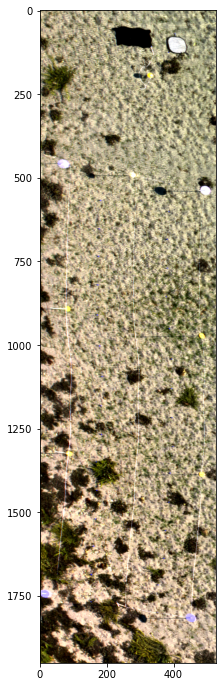

In [6]:
#%% Show image (contrast stretched to (2,98) percentiles)
im_rgb = im_full[:,:,rgb_ind]
im_rgb = exposure.rescale_intensity( im_rgb, in_range=tuple(np.percentile(im_rgb, (2,98))))

fig,ax = plt.subplots(figsize=(6,12))
plt.imshow(im_rgb)
plt.show()

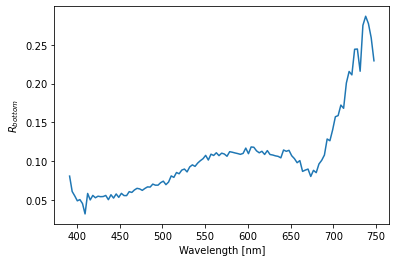

In [7]:
#%% Plot example spectrum
ex_spec = np.squeeze(im[900,400,:]) # Pixel in area with seagrass
plt.plot(wl,ex_spec)
plt.xlabel('Wavelength [nm]')
plt.ylabel('$R_{bottom}$')
plt.show()

In [8]:
#%% Load annotation class info from JSON file
# Read raw text
with open(ann_classes_json, 'r') as myfile:
    data=myfile.read()

# Parse JSON text into list
ann_class_info = json.loads( data)

In [9]:
#%% Build a simple dictionary with class numbers and names
class_dict = {}
for element in ann_class_info:
    class_dict[element['name']] = element['png_index']

In [10]:
#%% Print class dictionary
print('Class : Index \n')
for key,value in class_dict.items():
    print(key + ' : ' + str(value))

Class : Index 

Seagrass-0-25%-density : 1
Seagrass-25-50%-density : 2
Rock(s) : 3
Fucus-vesiculosus : 4
Green algae : 5
Ascophyllum-nodosum : 6
Fucus serratus : 7
Sand : 8
Blue mussels : 9
White-rope : 10
Bamboo-stick : 11
Blue-marker : 12
Red-marker : 13
Yellow-marker : 14
Gray-reference : 15
Black-reference : 16


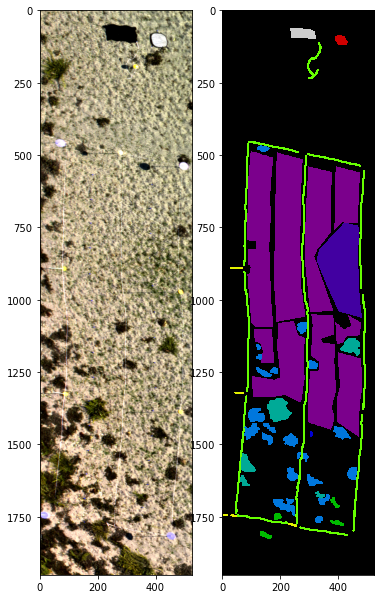

In [11]:
#%% Read and show class PNG file
class_mask = io.imread(ann_trans1_im)
class_mask = np.flip(class_mask,(0,1))    # Annotation image was rotated 180 deg, rotate back

fig,ax = plt.subplots(ncols=2,figsize=(6,12))
ax[0].imshow(im_rgb)
ax[1].imshow(class_mask,interpolation='none',cmap='nipy_spectral')
plt.show()

Note that the image has not been 100% annotated. Annotations are mainly limited to the transect, and areas where the vegetation was relatively homogenous. This method of annotation is OK for accessing training data. However, for validation of a classifier, the annotation should cover most (if not all) of the image.

Note also that the areas marked as seagrass are not marked "leaf by leaf", but rather as broad areas that contain a "mix" of sand and seagrass. Thus, some of the pixels in these classes are really "pure sand", but it is not feasible to separate these from the seagrass in manual annotation. This in turn has implications for the "purity" of the training data sets. It may be possible to achieve better separation of sand and seagrass using some kind of clustering (unsupervised) within the areas marked as seagrass.

In [12]:
#%% Create filtered/simplified list of classes to use in classification
classes_used = ['Sand',
                'Seagrass-0-25%-density',
                'Seagrass-25-50%-density',
                'Ascophyllum-nodosum',
                'Fucus-vesiculosus']

In [13]:
#%% Create class map with only selected (used) classes
class_map_simple = np.zeros(class_mask.shape)
for ii,name in enumerate(classes_used):
    class_map_simple[class_mask == class_dict[name]] = ii

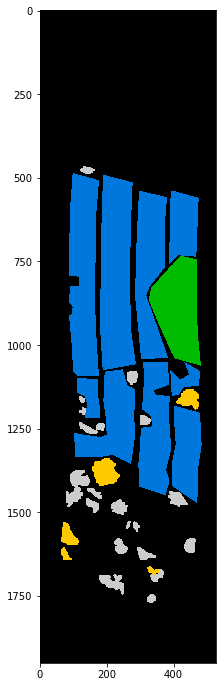

In [14]:
#%% Show class map with selected classes
fig,ax = plt.subplots(figsize=(6,12))
plt.imshow(class_map_simple,interpolation='none',cmap='nipy_spectral')
plt.show()

Note that in the above image, the areas for the "sand" class are not visible, since it is coded with index "0", which is the same coding as for non-annotated areas. This is not ideal, but is done for easier comparison with the classification result (see end of notebook).

In [15]:
#%% Extract training data (equal number of samples per class)

# Create random number generator
rng = np.random.default_rng()

# Create list for keeping sample data
class_sample_data = []

for name in classes_used:
    # Create boolean mask for class
    bool_mask = (class_mask == class_dict[name]) 
    
    # Randomly pick sample spectra indices, with replacement
    ind_y, ind_x = np.where(bool_mask)
    n_samples_total = len(ind_y) 
    rand_samp_ind = rng.choice(n_samples_total, n_samples_per_class, replace=True)

    # Add sample spectra to list
    class_sample_data.append(im_full[ind_y[rand_samp_ind], ind_x[rand_samp_ind],:])


Note that an equal number of samples is drawn for each class, even though the number of samples per class varies a lot between classes. This creates a balanced dataset. To allow any number of samples per class, the samples are drawn _with replacement_, i.e., some samples may be drawn multiple times. However, balancing the dataset is seen as more important than avoiding duplicates.

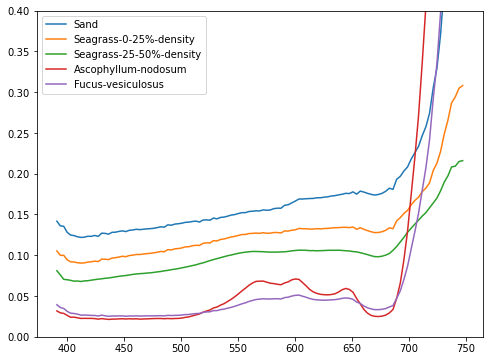

In [16]:
#%% Plot mean spectra for each class
fig,ax = plt.subplots(figsize=(8,6))
for ind,element in enumerate(class_sample_data):
    plt.plot(wl,element.mean(axis=0),label=classes_used[ind])

plt.ylim((0,0.4))
ax.legend()
plt.show()

Note that the mean spectra for the sand and seagrass classes are very similar in shape, but with different "baselines". This is due to the mix of sand and seagrass pixels discussed previously. However, we can see that some spectral shapes (dips, shoulder, peaks) become more pronounced as the density increases. The two brown algae have more distinct spectral shapes (especially *Ascophyllum n.*), which should make them relatively easy to detect.

In [17]:
#%% Create X and y for model traning (2D matrix and 1D vector)
X = np.asarray(class_sample_data)
X = np.reshape(X,(X.shape[0]*X.shape[1], X.shape[2]))

y = np.zeros((X.shape[0]))
for i in range(len(classes_used)):
    y[i*n_samples_per_class:(i+1)*n_samples_per_class] = i  # Integer class indexing

In [18]:
#%% Create pipeline for feature normalization, PCA and classification
clf = make_pipeline(StandardScaler(),PCA(n_components=8), RandomForestClassifier(n_estimators=20)) 

Here we create a simple classification pipeline consisting of 
* Scaling each feature to zero mean and unity variance
* Using PCA to reduce the number of features (to 8, in this case)
* A random forest classifier

This is by no means an "optimal" classifier, just an example of fairly typical preprocessing / classification tools for hyperspectral images. The "Spectronon" software uses a similar setup for its "auto classifier".

In [19]:
#%% Train the classifier pipeline
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=8)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=20))])

In [20]:
#%% Apply model to all pixels in image
X_im = np.reshape(im_full,(im_full.shape[0]*im_full.shape[1],im_full.shape[2]))
im_classified = np.reshape(clf.predict(X_im),(im_full.shape[0],im_full.shape[1]))

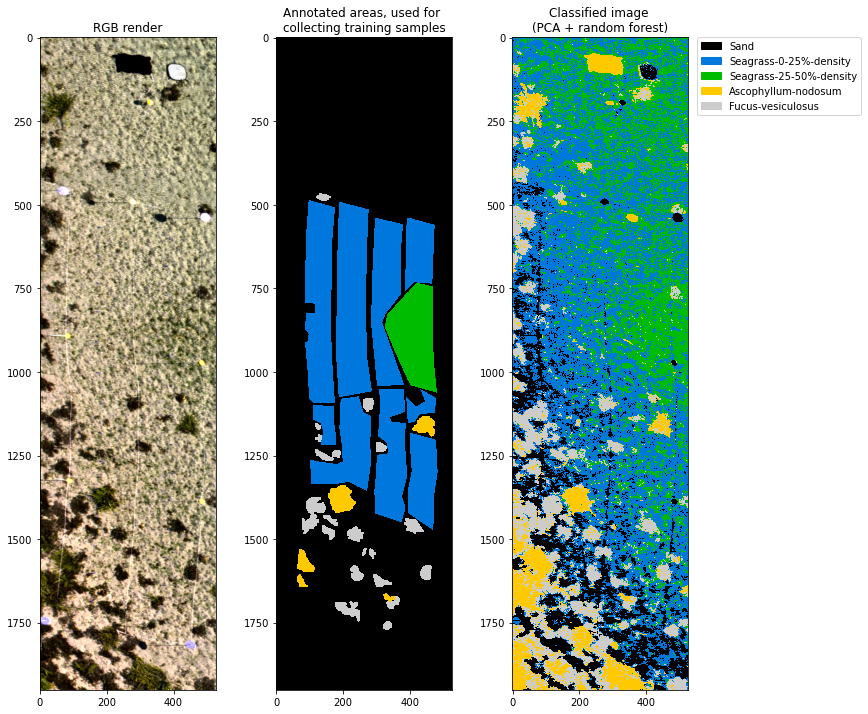

In [21]:
#%% Plot image, annotation and classification side by side
fig,ax = plt.subplots(ncols=3,figsize=(12,12))
ax[0].imshow(im_rgb)
ax[0].set_title('RGB render')
ax[1].imshow(class_map_simple,interpolation='none',cmap='nipy_spectral')
ax[1].set_title('Annotated areas, used for \ncollecting training samples')

cl_im = ax[2].imshow(im_classified,interpolation='none',cmap='nipy_spectral')
ax[2].set_title('Classified image \n(PCA + random forest)')


# Create classification plot legend
import matplotlib.patches as mpatches
values = np.arange(len(classes_used))
colors = [cl_im.cmap(cl_im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=classes_used[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

Note again that the annotation only covers "example areas" and not all instances of each class. The classification result shows that the brown algae (seen as dark spots in the RGB image) are mostly correctly classified, with fairly good separation between the two species. The sand and seagrass classes are much more "patchy", but the overall patterns make sense - especially the area of denser seagrass indicated with green color. The sand class (unfortunately not visible in annotation image) was also only sampled in the lower part of the image, which corresponds to an area that is slightly more shallow than most of the imaged area. This probably affects the classification, and the annotation could be revised to include samples from deeper areas.  